In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle

In [3]:
fama_french_factors = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=3)
fama_french_factors.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
#Delete annual data
fama_french_factors = fama_french_factors.iloc[:1165]
#Transform the date column to datetime format
fama_french_factors['Date'] = pd.to_datetime(fama_french_factors['Date'], format='%Y%m')
ff_after_70 = fama_french_factors[fama_french_factors['Date'] >= '1969-12-31']
fama_french_used = ff_after_70[ff_after_70['Date'] <= '2021-01-01']
fama_french_used.rename(columns={'Date': 'date'}, inplace=True)
fama_french_used.iloc[:,1:5] = fama_french_used.iloc[:,1:5].astype(float) / 100

C:\Users\berta\AppData\Local\Temp\ipykernel_16712\563772154.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fama_french_used.rename(columns={'Date': 'date'}, inplace=True)
C:\Users\berta\AppData\Local\Temp\ipykernel_16712\563772154.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fama_french_used.iloc[:,1:5] = fama_french_used.iloc[:,1:5].astype(float) / 100
C:\Users\berta\AppData\Local\Temp\ipykernel_16712\563772154.py:10: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new 

In [4]:
fama_french_used

,date,Mkt-RF,SMB,HML,RF
522,1970-01-01,-0.0810,0.0293,0.0313,0.0060
523,1970-02-01,0.0513,-0.0258,0.0393,0.0062
524,1970-03-01,-0.0106,-0.0232,0.0399,0.0057
525,1970-04-01,-0.1100,-0.0615,0.0618,0.0050
526,1970-05-01,-0.0692,-0.0459,0.0333,0.0053
...,...,...,...,...,...
1130,2020-09-01,-0.0363,0.0002,-0.0271,0.0001
1131,2020-10-01,-0.0210,0.0438,0.0425,0.0001
1132,2020-11-01,0.1247,0.0580,0.0209,0.0001
1133,2020-12-01,0.0463,0.0489,-0.0151,0.0001


Also add 19691231 to this. \
We roll the date forward by one month and replace the date with -0. This way it will be consistent with Fama-French.

In [5]:
all_data_ret_only = pd.read_pickle('all_data_greater_50.pkl')
# Open the data for 1969 december
nineteen_sixty_data = pd.read_csv('Data/monthly_data/data_for_month_19691231.csv')
# Get the permno, Date and ret columns from nineteen_sixty_data
nineteen_sixty_data = nineteen_sixty_data[['permno', 'DATE', 'RET']]
# Rename the DATE to date and RET to ret
nineteen_sixty_data.rename(columns={'DATE':'date', 'RET':'ret'}, inplace=True)
all_data_ret_only = pd.concat([nineteen_sixty_data, all_data_ret_only])
all_data_ret_only
#Convert the date column to datetime format
all_data_ret_only['date'] = pd.to_datetime(all_data_ret_only['date'], format='%Y%m%d')

# Add one month to the date column
# all_data_ret_only['date'] = all_data_ret_only['date'] + pd.DateOffset(months=1)

# Modify the dates such that they all have the first day of the month
all_data_ret_only['date'] = all_data_ret_only['date'].dt.strftime('%Y-%m-01')

# Convert the date column to datetime format
all_data_ret_only['date'] = pd.to_datetime(all_data_ret_only['date'], format='%Y-%m-%d')

In [6]:
all_data_ret_only

,permno,date,ret
0,10006,1969-12-01,-0.012594
1,10014,1969-12-01,-0.017241
2,10057,1969-12-01,0.027933
3,10065,1969-12-01,0.040650
4,10102,1969-12-01,-0.143791
...,...,...,...
3774785,93423,2020-12-01,0.109665
3774786,93426,2020-12-01,0.076239
3774787,93427,2020-12-01,0.135851
3774788,93434,2020-12-01,0.122605


In [4]:
def calculate_betas_20_years_before_test(data,factors_data, no_factors=3):
    first_date = '1990-01-01'
    last_date = '2010-01-01'
    temp_df = data[(data['date'] >= first_date) & (data['date'] < last_date)]
    val_counts = temp_df.permno.value_counts()
    #Drop the permnos that have less than 12 observations
    temp_df = temp_df[temp_df['permno'].isin(val_counts[val_counts >= 12].index)].reset_index(drop=True)
    factors_subset = factors_data[(factors_data['date'] >= first_date) & (factors_data['date'] < last_date)]
    temp_df = temp_df.merge(factors_subset, on='date', how='inner')
    permnos = temp_df['permno'].unique()
    print(len(permnos))
    beta_matrix = np.zeros((len(permnos), no_factors))
    alpha_matrix = np.zeros((len(permnos), 1))
    # Calculate the betas

    for i, per in enumerate(permnos):
        temp_subs = temp_df[temp_df['permno'] == per].sort_values(by=['date'])
        # Merge the temp_subs with factors_subset
        Y = temp_subs['ret'].values - temp_subs['RF'].values
        if no_factors == 3:
            X = temp_subs[['Mkt-RF', 'SMB', 'HML']].values
        else:
            X = temp_subs[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
        X = sm.add_constant(X)
        # print(factors_subset)
        # print(X.shape)
        # factor_values = 
        # print(factor_values.shape)
        # print(factor_values)
        model = sm.OLS(Y, X)
        results = model.fit()
        # print(results.params[1])
        # Get the coefficients of the OLS
        beta = results.params[1:]
        # print(f"For permno: {i}")
        # print(beta)
        # beta = results.params[1]
        beta_matrix[i,:] = beta
        #Get the intercept
        alpha = results.params[0]
        # print(alpha)
        alpha_matrix[i,:] = alpha
        print(f"Permno {i} calculated")
    
    #Create a dataframe from the betas and permnos
    if no_factors == 3:
        betas_df = pd.DataFrame(beta_matrix, columns=['Beta_1', 'Beta_2', 'Beta_3'], index=permnos)
    else:
        betas_df = pd.DataFrame(beta_matrix, columns=['Beta_1', 'Beta_2', 'Beta_3', 'Beta_4', 'Beta_5'], index=permnos)
    betas_df = betas_df.reset_index().rename(columns={'index':'permno'})
    alphas_df = pd.DataFrame(alpha_matrix, columns=['Alpha'], index=permnos)
    alphas_df = alphas_df.reset_index().rename(columns={'index':'permno'})
    #Merge the betas_df and alphas_df on permno
    betas_df = betas_df.merge(alphas_df, on='permno', how='inner')
    return betas_df

In [5]:
betas_df = calculate_betas_20_years_before_test(all_data_ret_only, fama_french_used)

10992
Permno 0 calculated
Permno 1 calculated
Permno 2 calculated
Permno 3 calculated
Permno 4 calculated
Permno 5 calculated
Permno 6 calculated
Permno 7 calculated
Permno 8 calculated
Permno 9 calculated
Permno 10 calculated
Permno 11 calculated
Permno 12 calculated
Permno 13 calculated
Permno 14 calculated
Permno 15 calculated
Permno 16 calculated
Permno 17 calculated
Permno 18 calculated
Permno 19 calculated
Permno 20 calculated
Permno 21 calculated
Permno 22 calculated
Permno 23 calculated
Permno 24 calculated
Permno 25 calculated
Permno 26 calculated
Permno 27 calculated
Permno 28 calculated
Permno 29 calculated
Permno 30 calculated
Permno 31 calculated
Permno 32 calculated
Permno 33 calculated
Permno 34 calculated
Permno 35 calculated
Permno 36 calculated
Permno 37 calculated
Permno 38 calculated
Permno 39 calculated
Permno 40 calculated
Permno 41 calculated
Permno 42 calculated
Permno 43 calculated
Permno 44 calculated
Permno 45 calculated
Permno 46 calculated
Permno 47 calcula

In [17]:
def add_last_ten_years(data, betas_df, factors_data, no_factors=3):
    first_date = '2010-01-01'
    temp_df = data[data['date'] >= first_date]
    temp_df = temp_df.merge(betas_df, on='permno', how='inner')
    factors_subset = factors_data[factors_data['date'] >= first_date]
    temp_df = temp_df.merge(factors_subset, on='date', how='inner')
    #Calculate the expected return by multiplying the betas with the factors
    if no_factors == 3:
        temp_df['Expected_Return'] = temp_df['Beta_1'] * temp_df['Mkt-RF'] + temp_df['Beta_2'] * temp_df['SMB'] + temp_df['Beta_3'] * temp_df['HML'] + temp_df['Alpha']
    else:
        temp_df['Expected_Return'] = temp_df['Beta_1'] * temp_df['Mkt-RF'] + temp_df['Beta_2'] * temp_df['SMB'] + temp_df['Beta_3'] * temp_df['HML'] + temp_df['Beta_4'] * temp_df['RMW'] + temp_df['Beta_5'] * temp_df['CMA'] + temp_df['Alpha']
    #Create the excess return column
    temp_df['Excess_Return'] = temp_df['ret'] - temp_df['RF']
    return temp_df

In [18]:
def create_total_r2(data):
    denom = np.sum((data['ret'].values)**2)
    nom = np.sum((data['Excess_Return'].values - data['Expected_Return'].values)**2)
    r_2 = 1 - nom / denom
    return r_2

### Calculate Total $R^{2}$

In [15]:
def calculate_whole_sample(data, betas_df, factors_data, no_factors=3):
    first_date = '1990-01-01'
    temp_df = data[(data['date'] >= first_date)]
    temp_df = temp_df.merge(betas_df, on='permno', how='inner')
    factors_subset = factors_data
    temp_df = temp_df.merge(factors_subset, on='date', how='inner')
    #Calculate the expected return by multiplying the betas with the factors
    if no_factors == 3:
        temp_df['Expected_Return'] = temp_df['Beta_1'] * temp_df['Mkt-RF'] + temp_df['Beta_2'] * temp_df['SMB'] + temp_df['Beta_3'] * temp_df['HML'] + temp_df['Alpha']
    else:
        temp_df['Expected_Return'] = temp_df['Beta_1'] * temp_df['Mkt-RF'] + temp_df['Beta_2'] * temp_df['SMB'] + temp_df['Beta_3'] * temp_df['HML'] + temp_df['Beta_4'] * temp_df['RMW'] + temp_df['Beta_5'] * temp_df['CMA'] + temp_df['Alpha']
    #Create the excess return column
    temp_df['Excess_Return'] = temp_df['ret'] - temp_df['RF']
    return temp_df

In [16]:
def calculate_predictive_r_2(total_data, no_factors=3):
    if no_factors == 3:
        lambda_df = total_data[(total_data['date'] >= '1990-01-01') & (total_data['date'] < '2010-01-01')][['permno','Alpha','Mkt-RF','SMB','HML']].groupby(by='permno').mean()
    else:
        lambda_df = total_data[(total_data['date'] >= '1990-01-01') & (total_data['date'] < '2010-01-01')][['permno','Alpha','Mkt-RF','SMB','HML', 'RMW', 'CMA']].groupby(by='permno').mean()
    lambda_df = lambda_df.reset_index()
    first_date = '2010-01-01'
    if no_factors == 3:
        temp_df = total_data[total_data['date'] >= first_date][['permno','date','ret','Beta_1',	'Beta_2','Beta_3','Excess_Return']]
        temp_df = temp_df.merge(lambda_df, on='permno', how='inner')
        temp_df['Expected_Return'] = temp_df['Beta_1'] * temp_df['Mkt-RF'] + temp_df['Beta_2'] * temp_df['SMB'] + temp_df['Beta_3'] * temp_df['HML'] + temp_df['Alpha']
    else:
        temp_df = total_data[total_data['date'] >= first_date][['permno','date','ret','Beta_1',	'Beta_2','Beta_3','Beta_4','Beta_5','Excess_Return']]
        temp_df = temp_df.merge(lambda_df, on='permno', how='inner')
        temp_df['Expected_Return'] = temp_df['Beta_1'] * temp_df['Mkt-RF'] + temp_df['Beta_2'] * temp_df['SMB'] + temp_df['Beta_3'] * temp_df['HML'] + temp_df['Beta_4'] * temp_df['RMW'] + temp_df['Beta_5']*temp_df['CMA'] + temp_df['Alpha']

    # Calculate the R^2 
    denom = np.sum((temp_df['Excess_Return'].values)**2)
    nom = np.sum((temp_df['Excess_Return'].values - temp_df['Expected_Return'].values)**2)
    r_2 = 1 - nom / denom
    return r_2
    

In [9]:
last_ten_years = add_last_ten_years(all_data_ret_only, betas_df, fama_french_used)

NameError: name 'betas_df' is not defined

In [10]:
len(last_ten_years.permno.unique())

4666

##### Out of Sample $R^{2}$ 

In [132]:
create_total_r2(last_ten_years)

0.028991887580371634

In [173]:
total_sample = calculate_whole_sample(all_data_ret_only, betas_df, fama_french_used)

<AxesSubplot: xlabel='date'>

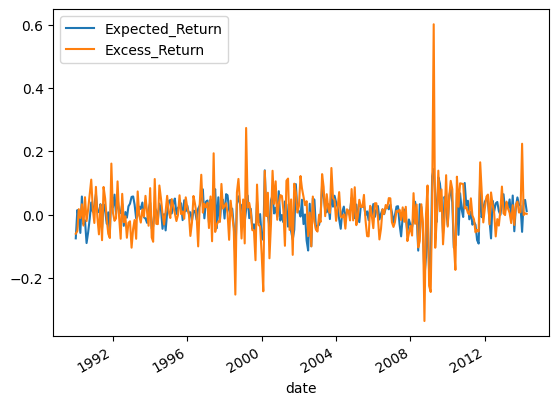

In [185]:
total_sample.query('permno == 10225').plot(x='date', y=['Expected_Return', 'Excess_Return'])

##### Total $R^{2}$ (In + Out of sample)

In [174]:
create_total_r2(total_sample)

0.14638688137966405

##### Predictive $R^{2}$

In [178]:
calculate_predictive_r_2(total_sample)

-0.014502548327389952

### Fama-French 5 factor Model

In [20]:
fama_french_5_factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=3)
# fama_french_5_factors.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
fama_french_5_factors.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
fama_french_5_factors = fama_french_5_factors.iloc[:724]

In [21]:
fama_french_5_factors['Date'] = pd.to_datetime(fama_french_5_factors['Date'], format='%Y%m')
fama_french_5_factors = fama_french_5_factors[fama_french_5_factors['Date'] >= '1969-12-31']
fama_french_5_factors = fama_french_5_factors[fama_french_5_factors['Date'] <= '2021-01-01']
fama_french_5_factors.rename(columns={'Date': 'date'}, inplace=True)
fama_french_5_factors.iloc[:,1:] = fama_french_5_factors.iloc[:,1:].astype(float) / 100

C:\Users\berta\AppData\Local\Temp\ipykernel_16712\3855768684.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  fama_french_5_factors.iloc[:,1:] = fama_french_5_factors.iloc[:,1:].astype(float) / 100


In [ ]:
betas_df_5 = calculate_betas_20_years_before_test(all_data_ret_only, fama_french_5_factors, no_factors=5)

#### Out of Sample

In [157]:
last_ten_years_5 = add_last_ten_years(all_data_ret_only, betas_df_5, fama_french_5_factors, no_factors=5)

In [182]:
create_total_r2(last_ten_years_5)

-0.020158106837358414

#### Total $R^{2}$ (In + Out of Sample)

In [180]:
total_sample_5 = calculate_whole_sample(all_data_ret_only, betas_df_5, fama_french_5_factors, no_factors=5)

In [181]:
create_total_r2(total_sample_5)

0.1626425860037891

#### Predictive R^{2}

In [183]:
calculate_predictive_r_2(total_sample_5, no_factors=5)

-0.01450254832738973

#### Evaluate only on PCA stocks

In [12]:
#Open the pca_cols pickle file

with open('pca_cols_os.pkl', 'rb') as f:
    pca_cols = pickle.load(f)
    
len(pca_cols)

3551

3 Factors

In [29]:
def calculate_betas_20_years_before_test_only_pca(data,factors_data, pca_cols, no_factors=3, first_date='1990-01-01', last_date='2010-01-01'):
    temp_df = data[(data['date'] >= first_date) & (data['date'] < last_date) & (data['permno'].isin(pca_cols))]
    val_counts = temp_df.permno.value_counts()
    #Drop the permnos that have less than 5 observations
    temp_df = temp_df[temp_df['permno'].isin(val_counts[val_counts >= 5].index)].reset_index(drop=True)
    factors_subset = factors_data[(factors_data['date'] >= first_date) & (factors_data['date'] < last_date)]
    temp_df = temp_df.merge(factors_subset, on='date', how='inner')
    permnos = temp_df['permno'].unique()
    print(len(permnos))
    beta_matrix = np.zeros((len(permnos), no_factors))
    alpha_matrix = np.zeros((len(permnos), 1))
    # Calculate the betas

    for i, per in enumerate(permnos):
        temp_subs = temp_df[temp_df['permno'] == per].sort_values(by=['date'])
        # Merge the temp_subs with factors_subset
        Y = temp_subs['ret'].values - temp_subs['RF'].values
        if no_factors == 3:
            X = temp_subs[['Mkt-RF', 'SMB', 'HML']].values
        else:
            X = temp_subs[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
        X = sm.add_constant(X)
        # print(factors_subset)
        # print(X.shape)
        # factor_values = 
        # print(factor_values.shape)
        # print(factor_values)
        model = sm.OLS(Y, X)
        results = model.fit()
        # print(results.params[1])
        # Get the coefficients of the OLS
        beta = results.params[1:]
        # print(f"For permno: {i}")
        # print(beta)
        # beta = results.params[1]
        beta_matrix[i,:] = beta
        #Get the intercept
        alpha = results.params[0]
        # print(alpha)
        alpha_matrix[i,:] = alpha
        print(f"Permno {i} calculated")
    
    #Create a dataframe from the betas and permnos
    if no_factors == 3:
        betas_df = pd.DataFrame(beta_matrix, columns=['Beta_1', 'Beta_2', 'Beta_3'], index=permnos)
    else:
        betas_df = pd.DataFrame(beta_matrix, columns=['Beta_1', 'Beta_2', 'Beta_3', 'Beta_4', 'Beta_5'], index=permnos)
    betas_df = betas_df.reset_index().rename(columns={'index':'permno'})
    alphas_df = pd.DataFrame(alpha_matrix, columns=['Alpha'], index=permnos)
    alphas_df = alphas_df.reset_index().rename(columns={'index':'permno'})
    #Merge the betas_df and alphas_df on permno
    betas_df = betas_df.merge(alphas_df, on='permno', how='inner')
    return betas_df

In [49]:
# Show the dates that are greater than or equal to 2010-01-01
all_data_ret_only[all_data_ret_only['date'] >= '2010-01-01']

,permno,date,ret
3022272,10001,2010-01-01,-0.018932
3022273,10002,2010-01-01,0.365854
3022274,10025,2010-01-01,-0.088036
3022275,10026,2010-01-01,0.046296
3022276,10028,2010-01-01,-0.028369
...,...,...,...
3774785,93423,2020-12-01,0.109665
3774786,93426,2020-12-01,0.076239
3774787,93427,2020-12-01,0.135851
3774788,93434,2020-12-01,0.122605


In [55]:
def add_last_ten_years_rolling(data, betas_in_samp, betas_out_sample, factors_data, no_factors=3):
    first_date = '2010-01-01'
    in_samp_df = data[data['date'] == first_date]
    in_samp_df = in_samp_df.merge(betas_in_samp, on='permno', how='inner')
    factors_in_samp = factors_data[factors_data['date'] == first_date]
    in_samp_df = in_samp_df.merge(factors_in_samp, on='date', how='inner')
    #Calculate the expected return by multiplying the betas with the factors
    if no_factors == 3:
        in_samp_df['Expected_Return'] = in_samp_df['Beta_1'] * in_samp_df['Mkt-RF'] + in_samp_df['Beta_2'] * in_samp_df['SMB'] + in_samp_df['Beta_3'] * in_samp_df['HML'] + in_samp_df['Alpha']
    else:
        in_samp_df['Expected_Return'] = in_samp_df['Beta_1'] * in_samp_df['Mkt-RF'] + in_samp_df['Beta_2'] * in_samp_df['SMB'] + in_samp_df['Beta_3'] * in_samp_df['HML'] + in_samp_df['Beta_4'] * in_samp_df['RMW'] + in_samp_df['Beta_5'] * in_samp_df['CMA'] + in_samp_df['Alpha']
    #Create the excess return column
    in_samp_df['Excess_Return'] = in_samp_df['ret'] - in_samp_df['RF']
    # For dates greater than 2010-01-01 use the betas_out_sample
    out_samp_df = data[data['date'] > first_date]
    # Loop over each date and calculate the return based on the betas_out_sample
    dates = out_samp_df['date'].unique()
    i = 0
    for date in dates:
        temp_df = out_samp_df[out_samp_df['date'] == date]
        temp_df = temp_df.merge(betas_out_sample[i*3551: (i+1)*3551], on='permno', how='inner')
        factors_out_samp = factors_data[factors_data['date'] == date]
        temp_df = temp_df.merge(factors_out_samp, on='date', how='inner')
        if no_factors == 3:
            temp_df['Expected_Return'] = temp_df['Beta_1'] * temp_df['Mkt-RF'] + temp_df['Beta_2'] * temp_df['SMB'] + temp_df['Beta_3'] * temp_df['HML'] + temp_df['Alpha']
        else:
            temp_df['Expected_Return'] = temp_df['Beta_1'] * temp_df['Mkt-RF'] + temp_df['Beta_2'] * temp_df['SMB'] + temp_df['Beta_3'] * temp_df['HML'] + temp_df['Beta_4'] * temp_df['RMW'] + temp_df['Beta_5'] * temp_df['CMA'] + temp_df['Alpha']
        #Create the excess return column
        temp_df['Excess_Return'] = temp_df['ret'] - temp_df['RF']
        in_samp_df = pd.concat([in_samp_df, temp_df])
        i += 1
    return in_samp_df

In [61]:
def calculate_in_sample_rolling(data, betas_in_samp, factors_data, last_date_in_sample='2010-01-01', first_date='1990-01-01',no_factors=3):
    temp_df = data[(data['date'] >= first_date) & (data['date'] < last_date_in_sample)]
    temp_df = temp_df.merge(betas_in_samp, on='permno', how='inner')
    factors_subset = factors_data
    temp_df = temp_df.merge(factors_subset, on='date', how='inner')
    #Calculate the expected return by multiplying the betas with the factors
    if no_factors == 3:
        temp_df['Expected_Return'] = temp_df['Beta_1'] * temp_df['Mkt-RF'] + temp_df['Beta_2'] * temp_df['SMB'] + temp_df['Beta_3'] * temp_df['HML'] + temp_df['Alpha']
    else:
        temp_df['Expected_Return'] = temp_df['Beta_1'] * temp_df['Mkt-RF'] + temp_df['Beta_2'] * temp_df['SMB'] + temp_df['Beta_3'] * temp_df['HML'] + temp_df['Beta_4'] * temp_df['RMW'] + temp_df['Beta_5'] * temp_df['CMA'] + temp_df['Alpha']
    #Create the excess return column
    temp_df['Excess_Return'] = temp_df['ret'] - temp_df['RF']
    return temp_df

In [43]:
def calculate_dynamic_betas_20_years_before_test_only_pca(data,factors_data, pca_cols, no_factors=3, first_date='1990-01-01', last_date_in_sample='2010-01-01',
                                                          last_date = '2021-01-01'):
    #In sample
    in_sample_betas = calculate_betas_20_years_before_test_only_pca(data,factors_data, pca_cols, no_factors=no_factors, first_date=first_date, last_date=last_date_in_sample)
    print(f"Calculated in sample betas")
    #Out of sample
    out_sample_beta_df = pd.DataFrame(columns=['permno', 'Beta_1', 'Beta_2', 'Beta_3', 'Alpha'])
    # For each unique date calculate rolling betas that incorporate all the data before that date
    dates = data[(data['date'] >  last_date_in_sample) & (data['date'] <last_date)]['date'].unique()
    # sort the dates in ascending order
    dates = np.sort(dates)
    for month in dates:
        #Get the data before that month
        temp_df = data[(data['date'] < month) & (data['date'] >= first_date)]
        #Get the betas for that month
        out_samp_beta = calculate_betas_20_years_before_test_only_pca(temp_df,factors_data, pca_cols, no_factors=no_factors, first_date=first_date, last_date=month)
        #Append the out_samp_beta to out_sample_beta_df
        out_sample_beta_df = out_sample_beta_df.append(out_samp_beta)
        print(f"Calculated out of sample betas for {month}")
    return in_sample_betas, out_sample_beta_df

## Dynamic Fama-French to Make it Comparable to IPCA and Autoencd

3 Factor Dynamic

In [ ]:
in_samp_betas, out_semple_beta_df = calculate_dynamic_betas_20_years_before_test_only_pca(all_data_ret_only, fama_french_used, pca_cols)

In [56]:
full_df = add_last_ten_years_rolling(all_data_ret_only, in_samp_betas, out_semple_beta_df, fama_french_used)

In [59]:
out_samp_r2 = create_total_r2(full_df)

In [63]:
in_sampl_data = calculate_in_sample_rolling(all_data_ret_only, in_samp_betas, fama_french_used)
total_data = pd.concat([in_sampl_data, full_df])
# Evaluate the R^2 for the total data
total_r2 = create_total_r2(total_data)

# Calculate the predictive R^2
predictive_r2 = calculate_predictive_r_2(total_data)

In [64]:
print(f"Out of sample R^2 is: {out_samp_r2}")
print(f"The total R^2 is: {total_r2}")
print(f"The predictive R^2 is: {predictive_r2}")


Out of sample R^2 is: 0.12766196181208234
The total R^2 is: 0.1771914133150676
The predictive R^2 is: 0.0006589309876018357


5 Factor Dynamic

In [66]:
in_samp_betas_5, out_semple_beta_df_5 = calculate_dynamic_betas_20_years_before_test_only_pca(all_data_ret_only, fama_french_5_factors, pca_cols, no_factors=5)

Permno 703 calculated
Permno 704 calculated
Permno 705 calculated
Permno 706 calculated
Permno 707 calculated
Permno 708 calculated
Permno 709 calculated
Permno 710 calculated
Permno 711 calculated
Permno 712 calculated
Permno 713 calculated
Permno 714 calculated
Permno 715 calculated
Permno 716 calculated
Permno 717 calculated
Permno 718 calculated
Permno 719 calculated
Permno 720 calculated
Permno 721 calculated
Permno 722 calculated
Permno 723 calculated
Permno 724 calculated
Permno 725 calculated
Permno 726 calculated
Permno 727 calculated
Permno 728 calculated
Permno 729 calculated
Permno 730 calculated
Permno 731 calculated
Permno 732 calculated
Permno 733 calculated
Permno 734 calculated
Permno 735 calculated
Permno 736 calculated
Permno 737 calculated
Permno 738 calculated
Permno 739 calculated
Permno 740 calculated
Permno 741 calculated
Permno 742 calculated
Permno 743 calculated
Permno 744 calculated
Permno 745 calculated
Permno 746 calculated
Permno 747 calculated
Permno 748

C:\Users\berta\AppData\Local\Temp\ipykernel_16712\3872383468.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out_sample_beta_df = out_sample_beta_df.append(out_samp_beta)


3551
Permno 0 calculated
Permno 1 calculated
Permno 2 calculated
Permno 3 calculated
Permno 4 calculated
Permno 5 calculated
Permno 6 calculated
Permno 7 calculated
Permno 8 calculated
Permno 9 calculated
Permno 10 calculated
Permno 11 calculated
Permno 12 calculated
Permno 13 calculated
Permno 14 calculated
Permno 15 calculated
Permno 16 calculated
Permno 17 calculated
Permno 18 calculated
Permno 19 calculated
Permno 20 calculated
Permno 21 calculated
Permno 22 calculated
Permno 23 calculated
Permno 24 calculated
Permno 25 calculated
Permno 26 calculated
Permno 27 calculated
Permno 28 calculated
Permno 29 calculated
Permno 30 calculated
Permno 31 calculated
Permno 32 calculated
Permno 33 calculated
Permno 34 calculated
Permno 35 calculated
Permno 36 calculated
Permno 37 calculated
Permno 38 calculated
Permno 39 calculated
Permno 40 calculated
Permno 41 calculated
Permno 42 calculated
Permno 43 calculated
Permno 44 calculated
Permno 45 calculated
Permno 46 calculated
Permno 47 calculat

C:\Users\berta\AppData\Local\Temp\ipykernel_16712\3872383468.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out_sample_beta_df = out_sample_beta_df.append(out_samp_beta)


In [67]:
full_df = add_last_ten_years_rolling(all_data_ret_only, in_samp_betas_5, out_semple_beta_df_5, fama_french_5_factors, no_factors=5)
out_samp_r2 = create_total_r2(full_df)

in_sampl_data = calculate_in_sample_rolling(all_data_ret_only, in_samp_betas_5, fama_french_5_factors, no_factors=5)
total_data = pd.concat([in_sampl_data, full_df])
# Evaluate the R^2 for the total data
total_r2 = create_total_r2(total_data)

# Calculate the predictive R^2
predictive_r2 = calculate_predictive_r_2(total_data, no_factors=5)

print(f"Out of sample R^2 is: {out_samp_r2}")
print(f"The total R^2 is: {total_r2}")
print(f"The predictive R^2 is: {predictive_r2}")

Out of sample R^2 is: 0.12294543001447189
The total R^2 is: 0.1925377902194092
The predictive R^2 is: 0.00033463550032519773


### Dynamic FF (Estimed only on the last 10 years like PCA)

In [ ]:
in_samp_betas, out_semple_beta_df = calculate_dynamic_betas_20_years_before_test_only_pca(all_data_ret_only, fama_french_used, pca_cols, first_date='2000-01-01')

In [ ]:
full_df = add_last_ten_years_rolling(all_data_ret_only, in_samp_betas, out_semple_beta_df, fama_french_used)
out_samp_r2 = create_total_r2(full_df)
in_sampl_data = calculate_in_sample_rolling(all_data_ret_only, in_samp_betas, fama_french_used)
total_data = pd.concat([in_sampl_data, full_df])
# Evaluate the R^2 for the total data
total_r2 = create_total_r2(total_data)

# Calculate the predictive R^2
predictive_r2 = calculate_predictive_r_2(total_data)

In [ ]:
print(f"Out of sample R^2 is: {out_samp_r2}")
print(f"The total R^2 is: {total_r2}")
print(f"The predictive R^2 is: {predictive_r2}")


Out of sample R^2 is: 0.12766196181208234
The total R^2 is: 0.1771914133150676
The predictive R^2 is: 0.0006589309876018357


### Static FF (for PCA stocks) but this is not used in Analysis

In [13]:
betas_df = calculate_betas_20_years_before_test_only_pca(all_data_ret_only, fama_french_used, pca_cols)

3551
Permno 0 calculated
Permno 1 calculated
Permno 2 calculated
Permno 3 calculated
Permno 4 calculated
Permno 5 calculated
Permno 6 calculated
Permno 7 calculated
Permno 8 calculated
Permno 9 calculated
Permno 10 calculated
Permno 11 calculated
Permno 12 calculated
Permno 13 calculated
Permno 14 calculated
Permno 15 calculated
Permno 16 calculated
Permno 17 calculated
Permno 18 calculated
Permno 19 calculated
Permno 20 calculated
Permno 21 calculated
Permno 22 calculated
Permno 23 calculated
Permno 24 calculated
Permno 25 calculated
Permno 26 calculated
Permno 27 calculated
Permno 28 calculated
Permno 29 calculated
Permno 30 calculated
Permno 31 calculated
Permno 32 calculated
Permno 33 calculated
Permno 34 calculated
Permno 35 calculated
Permno 36 calculated
Permno 37 calculated
Permno 38 calculated
Permno 39 calculated
Permno 40 calculated
Permno 41 calculated
Permno 42 calculated
Permno 43 calculated
Permno 44 calculated
Permno 45 calculated
Permno 46 calculated
Permno 47 calculat

In [19]:
last_ten_years = add_last_ten_years(all_data_ret_only, betas_df, fama_french_used, no_factors=3)
out_samp_r2 = create_total_r2(last_ten_years)

total_sample = calculate_whole_sample(all_data_ret_only, betas_df, fama_french_used, no_factors=3)
total_samp_r2 = create_total_r2(total_sample)

predictive_r2 = calculate_predictive_r_2(total_sample, no_factors=3)

print(f"Out of sample R^2: {out_samp_r2}")
print(f"Total sample R^2: {total_samp_r2}")
print(f"Predictive R^2: {predictive_r2}")

Out of sample R^2: 0.10461497393663621
Total sample R^2: 0.17054273148132548
Predictive R^2: 0.0005661507096360596


5 Factors

In [ ]:
betas_df = calculate_betas_20_years_before_test_only_pca(all_data_ret_only, fama_french_5_factors, pca_cols, no_factors=5)

3551
Permno 0 calculated
Permno 1 calculated
Permno 2 calculated
Permno 3 calculated
Permno 4 calculated
Permno 5 calculated
Permno 6 calculated
Permno 7 calculated
Permno 8 calculated
Permno 9 calculated
Permno 10 calculated
Permno 11 calculated
Permno 12 calculated
Permno 13 calculated
Permno 14 calculated
Permno 15 calculated
Permno 16 calculated
Permno 17 calculated
Permno 18 calculated
Permno 19 calculated
Permno 20 calculated
Permno 21 calculated
Permno 22 calculated
Permno 23 calculated
Permno 24 calculated
Permno 25 calculated
Permno 26 calculated
Permno 27 calculated
Permno 28 calculated
Permno 29 calculated
Permno 30 calculated
Permno 31 calculated
Permno 32 calculated
Permno 33 calculated
Permno 34 calculated
Permno 35 calculated
Permno 36 calculated
Permno 37 calculated
Permno 38 calculated
Permno 39 calculated
Permno 40 calculated
Permno 41 calculated
Permno 42 calculated
Permno 43 calculated
Permno 44 calculated
Permno 45 calculated
Permno 46 calculated
Permno 47 calculat

In [ ]:
last_ten_years = add_last_ten_years(all_data_ret_only, betas_df, fama_french_5_factors, no_factors=5)
out_samp_r2 = create_total_r2(last_ten_years)

total_sample = calculate_whole_sample(all_data_ret_only, betas_df, fama_french_5_factors, no_factors=5)
total_samp_r2 = create_total_r2(total_sample)

predictive_r2 = calculate_predictive_r_2(total_sample, no_factors=5)

print(f"Out of sample R^2: {out_samp_r2}")
print(f"Total sample R^2: {total_samp_r2}")
print(f"Predictive R^2: {predictive_r2}")

Out of sample R^2: 0.09577622080751791
Total sample R^2: 0.18469991445587552
Predictive R^2: 0.0005661507096368368


### Using Only Ten years

In [34]:
betas_df = calculate_betas_20_years_before_test_only_pca(all_data_ret_only, fama_french_used, pca_cols, first_date='2000-01-01')

3551
Permno 0 calculated
Permno 1 calculated
Permno 2 calculated
Permno 3 calculated
Permno 4 calculated
Permno 5 calculated
Permno 6 calculated
Permno 7 calculated
Permno 8 calculated
Permno 9 calculated
Permno 10 calculated
Permno 11 calculated
Permno 12 calculated
Permno 13 calculated
Permno 14 calculated
Permno 15 calculated
Permno 16 calculated
Permno 17 calculated
Permno 18 calculated
Permno 19 calculated
Permno 20 calculated
Permno 21 calculated
Permno 22 calculated
Permno 23 calculated
Permno 24 calculated
Permno 25 calculated
Permno 26 calculated
Permno 27 calculated
Permno 28 calculated
Permno 29 calculated
Permno 30 calculated
Permno 31 calculated
Permno 32 calculated
Permno 33 calculated
Permno 34 calculated
Permno 35 calculated
Permno 36 calculated
Permno 37 calculated
Permno 38 calculated
Permno 39 calculated
Permno 40 calculated
Permno 41 calculated
Permno 42 calculated
Permno 43 calculated
Permno 44 calculated
Permno 45 calculated
Permno 46 calculated
Permno 47 calculat

In [35]:
last_ten_years = add_last_ten_years(all_data_ret_only, betas_df, fama_french_used, no_factors=3)
out_samp_r2 = create_total_r2(last_ten_years)

total_sample = calculate_whole_sample(all_data_ret_only, betas_df, fama_french_used, no_factors=3)
total_samp_r2 = create_total_r2(total_sample)

predictive_r2 = calculate_predictive_r_2(total_sample, no_factors=3)

print(f"Out of sample R^2: {out_samp_r2}")
print(f"Total sample R^2: {total_samp_r2}")
print(f"Predictive R^2: {predictive_r2}")

Out of sample R^2: 0.09110216551520656
Total sample R^2: 0.15912403472168757
Predictive R^2: -0.0030035617666386294


5 Factors

In [36]:
betas_df = calculate_betas_20_years_before_test_only_pca(all_data_ret_only, fama_french_5_factors, pca_cols,first_date='2000-01-01', no_factors=5)

3551
Permno 0 calculated
Permno 1 calculated
Permno 2 calculated
Permno 3 calculated
Permno 4 calculated
Permno 5 calculated
Permno 6 calculated
Permno 7 calculated
Permno 8 calculated
Permno 9 calculated
Permno 10 calculated
Permno 11 calculated
Permno 12 calculated
Permno 13 calculated
Permno 14 calculated
Permno 15 calculated
Permno 16 calculated
Permno 17 calculated
Permno 18 calculated
Permno 19 calculated
Permno 20 calculated
Permno 21 calculated
Permno 22 calculated
Permno 23 calculated
Permno 24 calculated
Permno 25 calculated
Permno 26 calculated
Permno 27 calculated
Permno 28 calculated
Permno 29 calculated
Permno 30 calculated
Permno 31 calculated
Permno 32 calculated
Permno 33 calculated
Permno 34 calculated
Permno 35 calculated
Permno 36 calculated
Permno 37 calculated
Permno 38 calculated
Permno 39 calculated
Permno 40 calculated
Permno 41 calculated
Permno 42 calculated
Permno 43 calculated
Permno 44 calculated
Permno 45 calculated
Permno 46 calculated
Permno 47 calculat

In [37]:
last_ten_years = add_last_ten_years(all_data_ret_only, betas_df, fama_french_5_factors, no_factors=5)
out_samp_r2 = create_total_r2(last_ten_years)

total_sample = calculate_whole_sample(all_data_ret_only, betas_df, fama_french_5_factors, no_factors=5)
total_samp_r2 = create_total_r2(total_sample)

predictive_r2 = calculate_predictive_r_2(total_sample, no_factors=5)

print(f"Out of sample R^2: {out_samp_r2}")
print(f"Total sample R^2: {total_samp_r2}")
print(f"Predictive R^2: {predictive_r2}")

Out of sample R^2: 0.08007066106030591
Total sample R^2: 0.16886362569842162
Predictive R^2: -0.003016571828911685
